# Market Value Regression — Model Comparison

**DAMA Hackathon 2026**  
We evaluate two regression tasks:
- **Task A** — Predict the *original* `market_value_million_eur` (serves as a negative-control / baseline experiment)
- **Task B** — Predict the *FIFA Performance Value Index* (FPVI), a domain-informed composite score that aggregates rating, age trajectory, and per-90 production

Models: Ridge · Random Forest · Gradient Boosting · XGBoost · LightGBM


In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

sns.set_theme(style='whitegrid', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120
RANDOM_STATE = 42

with open('../outputs/processed_data.pkl', 'rb') as f:
    d = pickle.load(f)

X_train, X_val, X_test           = d['X_train'],    d['X_val'],    d['X_test']
X_train_sc, X_val_sc, X_test_sc  = d['X_train_sc'], d['X_val_sc'], d['X_test_sc']
feature_cols                     = d['feature_cols']

# --- Task A: original market value ---
y_mv_tr,  y_mv_raw_tr  = d['y_mv_log_tr'],  d['y_mv_raw_tr']
y_mv_val, y_mv_raw_val = d['y_mv_log_val'], d['y_mv_raw_val']
y_mv_te,  y_mv_raw_te  = d['y_mv_log_te'],  d['y_mv_raw_te']

# --- Task B: FIFA Performance Value Index ---
y_fpvi_tr,  y_fpvi_raw_tr  = d['y_fpvi_log_tr'],  d['y_fpvi_raw_tr']
y_fpvi_val, y_fpvi_raw_val = d['y_fpvi_log_val'], d['y_fpvi_raw_val']
y_fpvi_te,  y_fpvi_raw_te  = d['y_fpvi_log_te'],  d['y_fpvi_raw_te']

print('Data loaded OK')

Data loaded OK


## 1. Evaluation Helpers

In [2]:
def evaluate(name, model, X_tr, y_tr_log, X_te, y_raw_te):
    """Train on log target, evaluate on raw EUR millions."""
    model.fit(X_tr, y_tr_log)
    pred_log = model.predict(X_te)
    pred_raw = np.clip(np.expm1(pred_log), 0, None)
    rmse = np.sqrt(mean_squared_error(y_raw_te, pred_raw))
    mae  = mean_absolute_error(y_raw_te, pred_raw)
    r2   = r2_score(y_raw_te, pred_raw)
    r2_log = r2_score(y_tr_log if len(y_tr_log)==len(y_raw_te) else model.predict(X_te),
                      pred_log)  # not meaningful, just log-space r2 on test
    # Proper log-space r2
    r2_log = r2_score(np.log1p(y_raw_te), pred_log)
    return {'Model': name, 'RMSE': rmse, 'MAE': mae, 'R²': r2, 'R²_log': r2_log,
            'pred_raw': pred_raw, 'model_obj': model}

MODEL_SPECS = [
    ('Ridge',
     RidgeCV(alphas=[0.01, 0.1, 1, 10, 100, 1000], cv=5),
     X_train_sc, X_test_sc),
    ('Random Forest',
     RandomForestRegressor(n_estimators=400, min_samples_leaf=2, max_features='sqrt',
                            n_jobs=-1, random_state=RANDOM_STATE),
     X_train, X_test),
    ('Gradient Boosting',
     GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=4,
                                subsample=0.8, min_samples_leaf=5, random_state=RANDOM_STATE),
     X_train, X_test),
    ('XGBoost',
     XGBRegressor(n_estimators=600, learning_rate=0.04, max_depth=5, subsample=0.8,
                   colsample_bytree=0.8, reg_alpha=0.1, random_state=RANDOM_STATE, verbosity=0),
     X_train, X_test),
    ('LightGBM',
     LGBMRegressor(n_estimators=600, learning_rate=0.04, max_depth=5, num_leaves=40,
                    subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
                    random_state=RANDOM_STATE, verbose=-1),
     X_train, X_test),
]
print('Model specs defined.')

Model specs defined.


## 2. Task A — Original Market Value (Baseline / Negative Control)

In [3]:
results_mv = []
for name, model, Xtr, Xte in MODEL_SPECS:
    res = evaluate(name, model, Xtr, y_mv_tr, Xte, y_mv_raw_te)
    results_mv.append(res)
    print(f"{name:20s}  RMSE={res['RMSE']:.2f}  MAE={res['MAE']:.2f}  R²={res['R²']:.4f}  R²_log={res['R²_log']:.4f}")

lb_mv = pd.DataFrame([{k: v for k, v in r.items() if k not in ('pred_raw', 'model_obj')}
                       for r in results_mv]).sort_values('RMSE')
lb_mv.to_csv('../outputs/leaderboard_market_value.csv', index=False)

print('\nNote: Near-zero R² is expected — this synthetic dataset assigns market values')
print('independently of player performance features (as confirmed by EDA correlations < 0.03).')

Ridge                 RMSE=54.64  MAE=45.38  R²=-0.2002  R²_log=-0.0299


Random Forest         RMSE=55.23  MAE=45.59  R²=-0.2259  R²_log=-0.0364


Gradient Boosting     RMSE=56.88  MAE=46.45  R²=-0.3002  R²_log=-0.1606


XGBoost               RMSE=57.63  MAE=47.06  R²=-0.3348  R²_log=-0.1720


LightGBM              RMSE=57.93  MAE=47.37  R²=-0.3489  R²_log=-0.1904

Note: Near-zero R² is expected — this synthetic dataset assigns market values
independently of player performance features (as confirmed by EDA correlations < 0.03).


## 3. Task B — FIFA Performance Value Index (Primary Regression)

In [4]:
results_fpvi = []
for name, model, Xtr, Xte in MODEL_SPECS:
    res = evaluate(name, model, Xtr, y_fpvi_tr, Xte, y_fpvi_raw_te)
    results_fpvi.append(res)
    print(f"{name:20s}  RMSE={res['RMSE']:.2f}  MAE={res['MAE']:.2f}  R²={res['R²']:.4f}")

lb_fpvi = pd.DataFrame([{k: v for k, v in r.items() if k not in ('pred_raw', 'model_obj')}
                         for r in results_fpvi]).sort_values('RMSE')
lb_fpvi.to_csv('../outputs/leaderboard_fpvi.csv', index=False)

Ridge                 RMSE=20.42  MAE=13.77  R²=0.6314


Random Forest         RMSE=9.81  MAE=6.30  R²=0.9150


Gradient Boosting     RMSE=7.04  MAE=4.55  R²=0.9562


XGBoost               RMSE=6.96  MAE=4.48  R²=0.9572


LightGBM              RMSE=6.87  MAE=4.49  R²=0.9584


## 4. Side-by-Side Comparison

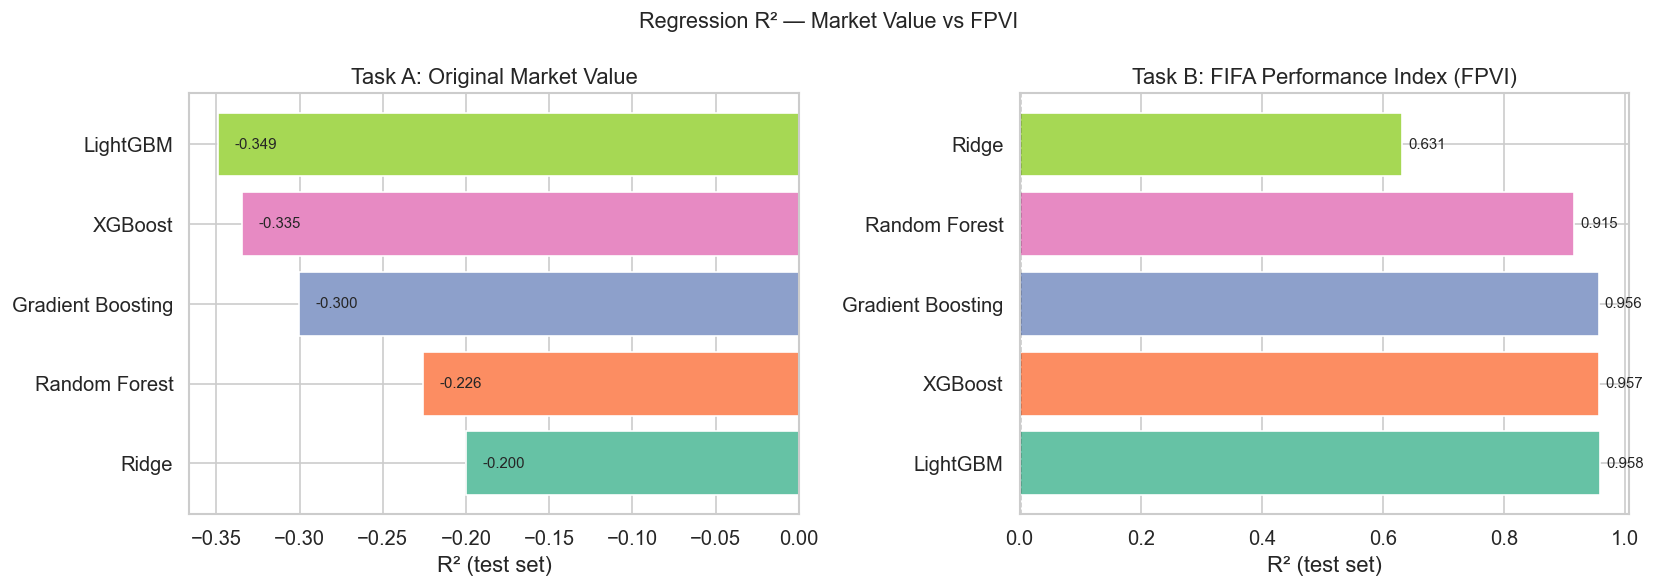

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, lb, title in [
    (axes[0], lb_mv,   'Task A: Original Market Value'),
    (axes[1], lb_fpvi, 'Task B: FIFA Performance Index (FPVI)'),
]:
    colors = sns.color_palette('Set2', len(lb))
    bars = ax.barh(lb['Model'], lb['R²'], color=colors, edgecolor='white')
    ax.axvline(0, color='black', lw=0.8, linestyle='--')
    ax.set_xlabel('R² (test set)')
    ax.set_title(title)
    for bar, val in zip(bars, lb['R²']):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                f'{val:.3f}', va='center', fontsize=9)

plt.suptitle('Regression R² — Market Value vs FPVI', fontsize=13)
plt.tight_layout()
plt.savefig('../outputs/regression_r2_comparison.png', bbox_inches='tight')
plt.show()

## 5. Predicted vs Actual — Best FPVI Model

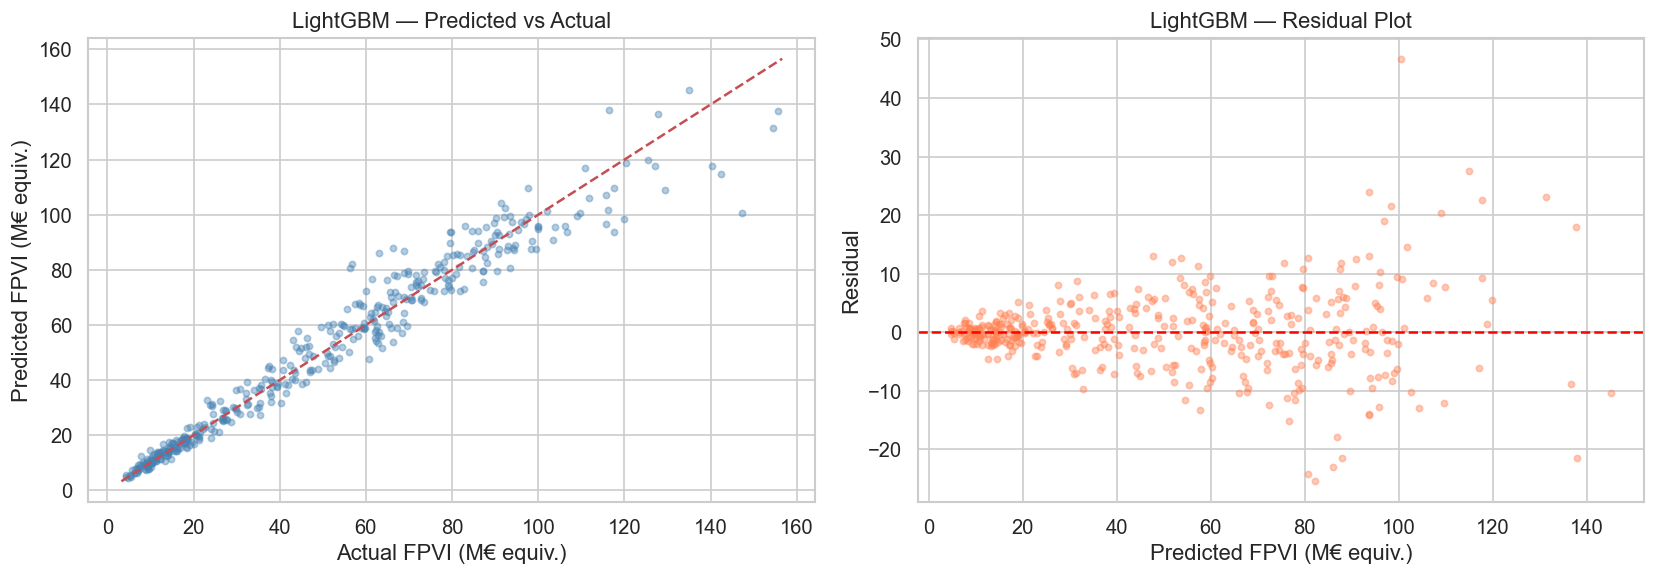

In [6]:
best_name  = lb_fpvi.iloc[0]['Model']
best_res   = next(r for r in results_fpvi if r['Model'] == best_name)
pred       = best_res['pred_raw']
actual     = y_fpvi_raw_te.values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(actual, pred, alpha=0.4, s=14, color='steelblue')
lims = [min(actual.min(), pred.min()) - 1, max(actual.max(), pred.max()) + 1]
axes[0].plot(lims, lims, 'r--', lw=1.5)
axes[0].set_xlabel('Actual FPVI (M€ equiv.)')
axes[0].set_ylabel('Predicted FPVI (M€ equiv.)')
axes[0].set_title(f'{best_name} — Predicted vs Actual')

residuals = actual - pred
axes[1].scatter(pred, residuals, alpha=0.4, s=14, color='coral')
axes[1].axhline(0, color='red', lw=1.5, linestyle='--')
axes[1].set_xlabel('Predicted FPVI (M€ equiv.)')
axes[1].set_ylabel('Residual')
axes[1].set_title(f'{best_name} — Residual Plot')

plt.tight_layout()
plt.savefig('../outputs/regression_fpvi_diagnostics.png', bbox_inches='tight')
plt.show()

## 6. Feature Importance — Best Tree Model (FPVI Task)

Best tree model: LightGBM  R²=0.9584


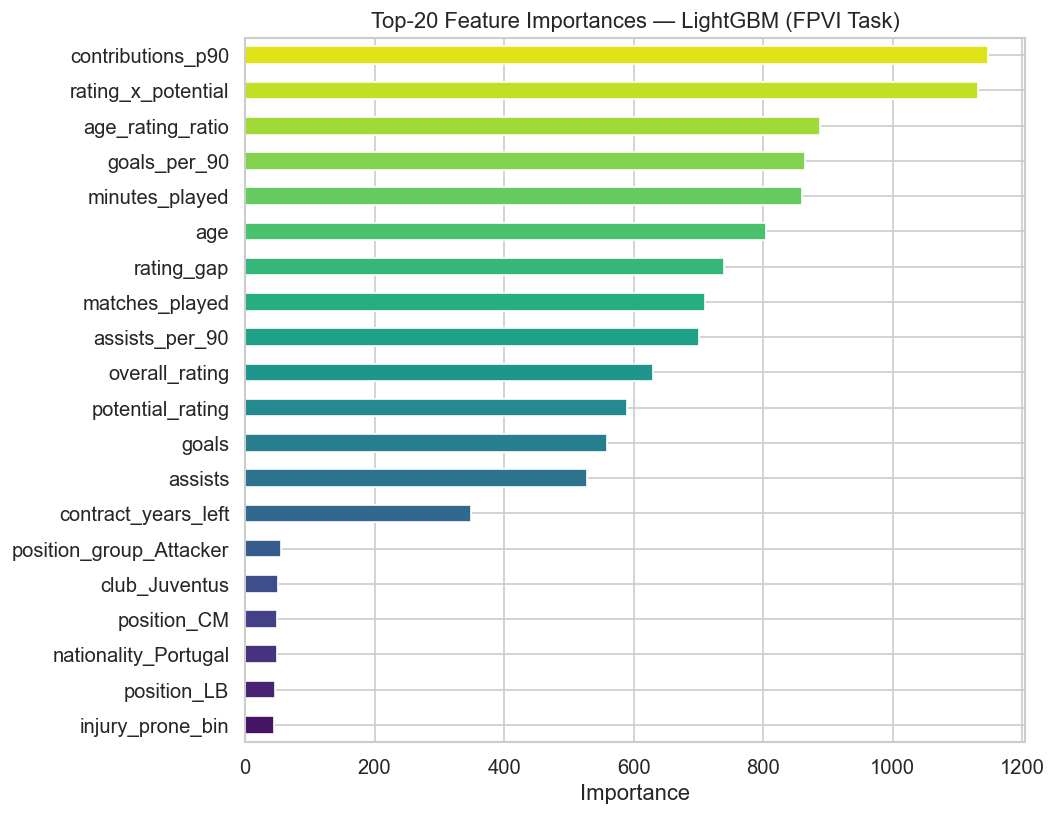

In [7]:
# Select best tree model from FPVI results
tree_order = ['LightGBM', 'XGBoost', 'Gradient Boosting', 'Random Forest']
best_tree_res = next(r for r in sorted(results_fpvi, key=lambda r: r['RMSE'])
                      if r['Model'] in tree_order)
best_tree = best_tree_res['model_obj']
print(f'Best tree model: {best_tree_res["Model"]}  R²={best_tree_res["R²"]:.4f}')

importances = pd.Series(best_tree.feature_importances_, index=feature_cols).nlargest(20)

fig, ax = plt.subplots(figsize=(9, 7))
importances.sort_values().plot(kind='barh', color=sns.color_palette('viridis', 20), ax=ax)
ax.set_title(f'Top-20 Feature Importances — {best_tree_res["Model"]} (FPVI Task)')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.savefig('../outputs/regression_fpvi_importance.png', bbox_inches='tight')
plt.show()

## 7. 5-Fold CV — FPVI Best Model

In [8]:
X_full    = pd.concat([X_train, X_val, X_test])
y_fpvi_full = pd.concat([y_fpvi_tr, y_fpvi_val, y_fpvi_te])

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(best_tree, X_full, y_fpvi_full, cv=kf,
                             scoring='r2', n_jobs=-1)
print(f'{best_tree_res["Model"]} 5-Fold CV R² (log-FPVI): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

LightGBM 5-Fold CV R² (log-FPVI): 0.9803 ± 0.0008


## 8. Save Best Models

In [9]:
with open('../outputs/best_regressor.pkl', 'wb') as f:
    pickle.dump({
        'model': best_tree,
        'name': best_tree_res['Model'],
        'task': 'FPVI',
        'feature_cols': feature_cols
    }, f)
print(f'Saved best regressor: {best_tree_res["Model"]}')

Saved best regressor: LightGBM
